# RF 데모
- 각각의 모델의 피처를 랜덤으로 골라 학습하여 조합하는 방법  
  여러 결정트리를 랜덤 피처 + 랜덤 샘플 로 학습 후 조합(bagging)
  =>배깅을 조합하여 예측하는 방법이 지금의 여러 결정트리 = Random forest  
  [Model Error_Noise(irreducible error) + bias + variance]  
 > Bias_지속적으로 잘못된 것들을 학습하는 경향  
  (예측값은 원래값과 차이가 크다)  
  Variance_너무 세세한 부분까지 학습하여 모델을 만들다보니 새로운 데이터에 예민  
  (원래값이 1일 경우 평균 값은 1이지만 개별적으로 보면 -100과 100이 범위를 넘나듬)

- 단일DT
  많은 오버피팅, 얀간의 변화된 학습데이터와 인자에 예민함  
  low bias + high variance--> 전체적 성능 안좋음
- RF  
  여러 조합으로 높은 분산을 감소시켜 전체적인 성능을 높여준다.  

## 라이브러리 import 및 설정

In [11]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

rcParams['figure.figsize'] = (16, 8)               #그림 사이즈 지정
plt.style.use('fivethirtyeight')                   #그림 기본 스타일
pd.set_option('max_columns', 100)                  #칼럼 100개 허용
pd.set_option("display.precision", 4)              #소수점 4자리허용
warnings.simplefilter('ignore')                    #경고분 무시

## 학습데이터 로드

In [13]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\testset.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\trainset.csv'

df= pd.read_csv(feature_file,index_col=0)          #학습/시험 데이터 
print(df.shape)                                    #(6113, 32)
df.head()                                          #위 5개            

(6113, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,188,128,95,114,143,108,88,103,113,85,88,113,87,88,103,87,84,99,104,82,96,100,78,70,79,84,66,70,75,76,63,HI
1,174,112,88,104,119,92,74,79,88,74,67,90,68,71,73,68,71,77,90,67,71,82,65,70,75,89,73,67,71,89,73,PH
2,175,138,106,105,135,109,75,95,113,96,74,112,96,70,87,100,66,83,117,67,88,110,98,67,88,119,98,75,91,110,94,GR
3,176,111,80,106,131,96,76,99,104,85,75,89,75,79,91,75,84,103,109,82,91,96,78,78,91,96,78,82,104,112,85,PH
4,182,144,111,100,151,119,67,106,114,90,76,115,94,68,106,91,68,102,115,71,95,108,88,71,103,113,92,68,107,118,92,EL


In [14]:
y = df.iloc[:,31].values[:4280]                    #학습_종속 4280개
df.drop(df.columns[[31]], axis=1, inplace=True)    #독립을 위한 종속 제거
trn = df.iloc[:4280]                               #학습데이터_독립 4280개
tst = df.iloc[4280:]                               #시험데이터_독립 1833개
print(y.shape, trn.shape, tst.shape)               #(4280,) (4280, 31) (1833, 31)

(4280,) (4280, 31) (1833, 31)


In [15]:
seed = 150
#적정값이 있었음 너무 낮거나 높음 떨어짐
#107: 91.2383%   150: 91.7056%  100: 90.7710%

## 학습/검증 데이터 구분
학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리

#### [Hold-out Validation]

In [16]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(3424, 31) (856, 31) (3424,) (856,)


## Hyperparameter Tuning

In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_trn, y_trn).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'min_samples_leaf':hp.choice('min_samples_leaf',range(8,18)),
    'min_samples_split':hp.choice('min_samples_split',range(4,40)),
    'max_features': hp.choice('max_features', range(1,150)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
0                                                                                                                      
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 136, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 139}
new best:                                                                                                              
0                                                                                                                      
{'criterion': 'gini', 'max_depth': 13, 'max_features': 97, 'min_samples_leaf': 11, 'min_samples_split': 22, 'n_estimators': 261}
new best:                                                                                                              
0                                                                                                                      
{'criterion': 'entro

new best:                                                                                                              
0.8785064242113801                                                                                                     
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 133, 'min_samples_leaf': 12, 'min_samples_split': 25, 'n_estimators': 256}
new best:                                                                                                              
0.883471208434712                                                                                                      
{'criterion': 'gini', 'max_depth': 16, 'max_features': 8, 'min_samples_leaf': 9, 'min_samples_split': 30, 'n_estimators': 197}
new best:                                                                                                              
0.883471208434712                                                                                                      
{'criterion': 'gini',

new best:                                                                                                              
0.883471208434712                                                                                                      
{'criterion': 'gini', 'max_depth': 2, 'max_features': 134, 'min_samples_leaf': 10, 'min_samples_split': 27, 'n_estimators': 289}
new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 14, 'min_samples_leaf': 9, 'min_samples_split': 29, 'n_estimators': 137}
new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'entro

new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'gini', 'max_depth': 18, 'max_features': 76, 'min_samples_leaf': 13, 'min_samples_split': 39, 'n_estimators': 411}
new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 17, 'min_samples_split': 37, 'n_estimators': 164}
new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'entr

new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'gini', 'max_depth': 9, 'max_features': 127, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 393}
new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 114, 'min_samples_leaf': 12, 'min_samples_split': 7, 'n_estimators': 422}
new best:                                                                                                              
0.8872672557305673                                                                                                     
{'criterion': 'entrop

## Random Forest 모델 학습 

In [23]:
clf = RandomForestClassifier(n_estimators=30000,
                             min_samples_leaf=10,
                             max_depth=15,
                             max_features='auto',
                             max_samples=.5,
                             random_state=seed,
                             n_jobs=-1)
clf.fit(X_trn, y_trn)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

** ( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() ) **

In [24]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')
#n_e 만 3000 91.7056% but cv_90.374
#5000 max_depth50 91.8224% 90.444
#5000 min_samples_split=18,89.6028% 89.346
#5000 min_samples_leaf=17,88.5514%
#HW7-rf92.0561% 91.192
#강사8-rf-cv88.0841  88.435

88.2009%


## 피처 중요도 시각화
여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

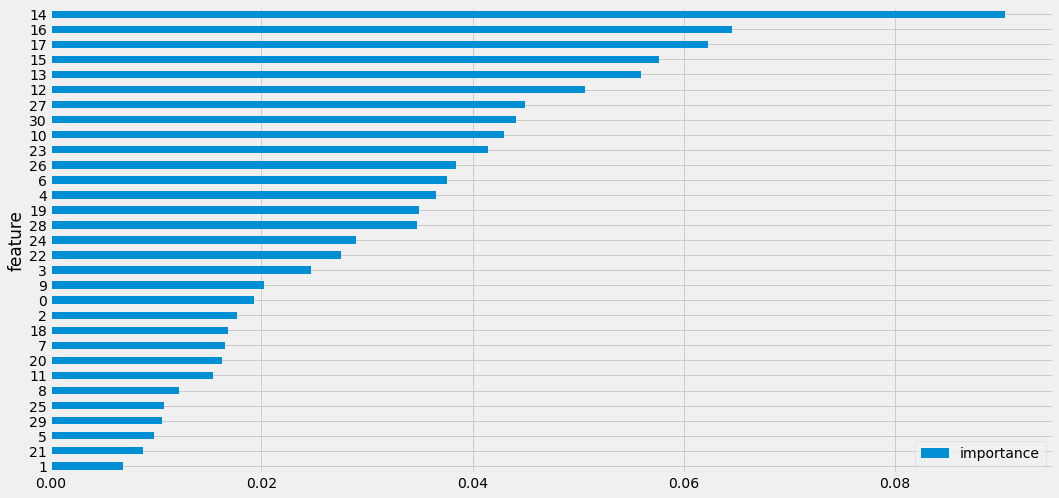

In [9]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [10]:
#sub = pd.read_csv(sample_file)
#sub['class']
sub = pd.read_csv(sample_file)
sub['class'] = p_tst
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\rf-sub.csv',index=False,header=False)